# Projeção de Natalidade para Projeção Populacional da Região Metropolitana de Curitiba

Este documento apresenta os procedimentos realizados para obtenção, tratamento, análise e projeção dos dados de natalidade por grupos de faixa etária das mulheres na Região Metropolitana de Curitiba. O resultado do modelo serão utilizados para projeção da população da região pelo método de coortes, e será utilizado para os diagnósticos e prognósticos que compõem parte do processo de elaboração do seu Plano de Desenvolvimento Integrado.

O documento traz detalhamento das rotinas computacionais em linguagem Python utilizada, para garantir reproducibilidade e verificação do rigor técnico por parte de quaisquer interessados.

## Preparação do _Notebook_

Esse documento, por ser construído em Linguagem Python, apresenta textos e código, por essa razão, sua preparação depende de importação das bibliotecas que serão utilizadas nos procedimentos analíticos.

In [1]:
import pandas as pd # importação de biblioteca de manipulação de dados tabulares
import matplotlib.pyplot as plt # importação de biblioteca de plotagem de gráficos 
import numpy as np # importação de biblioteca para cálculos matemáticos
from scipy.optimize import curve_fit # importação de função a ser utilizada para ajuste de modelo preditivo 
from itertools import product # importação de função voltada para otimização de laços de iteração
import warnings

## Carregamento e Tratamento Dados de Nascidos Vivos
Os dados de nascimentos foram obtidos a partir do [Sistema de Informações sobre Nascidos Vivos (SINASC)](http://sinasc.saude.gov.br/), do Ministério da Saúde. O arquivo csv original passou por poucos tratamentos, contando apenas com retirada de metadados, informações de cabeçalho e registros com traços "-" alterados para 0, além de remoção de totais por ano e para todo o período de 1994 a 2021. 
Adiante os dados são importados e é feita adequação de nome de coluna para manutenção de mesmo padrão utilizado para os dados de patamar populacional de mulheres por faixa etária.
Para conferência dos dados, as duas primeiras e as duas últimas linhas da tabela são exibidas

In [2]:
df_nascimentos = pd.read_csv('./source/tab/originais/nascidos_vivos_idade_mae_tratado.csv', sep=';') #carregamento dos dados
df_nascimentos.rename(columns={'Idade da mãe':'Faixa Etária'}, inplace=True)
df_nascimentos.iloc[np.r_[0:2, -2:0]] #visualização das duas primeiras e das duas últimas linhas do DataFrame

,Faixa Etária,1994,1995,1996,1997,1998,1999,2000,2001,2002,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,10 a 14 anos,330,358,417,436,447,366,359,397,356,...,345,349,323,298,226,203,158,152,131,111
1,15 a 19 anos,9997,10625,11518,11576,11833,11735,10950,10697,9891,...,8254,8514,7907,7549,6556,5761,5265,4698,4147,3710
10,60 a 64 anos,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
11,Idade ignorada,4407,1717,1149,665,399,360,90,64,14,...,0,0,0,0,2,0,0,0,0,0


### Tratamento de Dados Nascimentos com Idade da Mãe Ignorada

A coluna "Idade da mãe" contava com marção de "Idade ignorada", para os casos em que os nascimentos não apresentaram registro de idade da mãe. Esses dados foram distribuídos por faixas etárias, conforme a proporção de nascimentos com idade identificada. Em seguida, foram removidas as linhas com registro de "Idade Ignorada".

In [3]:
for ano in df_nascimentos.columns[1:]:

    #obtendo número de mortes com idade ignorada para determinado sexo em determinado ano
    obitos_idade_ignorada = df_nascimentos[df_nascimentos['Faixa Etária'] =='Idade ignorada'][ano].to_numpy()

    #obtendo número de mortes com idade ignorada para determinado sexo em determinado ano 
    obitos_por_faixa_etaria = df_nascimentos[df_nascimentos['Faixa Etária'] != 'Idade ignorada'][ano].sum()
    
    # ponderando o número de óbitos sem marca de idade conforme a proporção de óbitos de cada Idade da mãe
    obitos_sem_idade_redistribuidos = (
        df_nascimentos[
            df_nascimentos['Faixa Etária'] != 'Idade ignorada'
            ][ano].to_numpy() * 1/obitos_por_faixa_etaria * obitos_idade_ignorada
            ).round().astype(int)
    
    # somando o número ponderado de óbitos sem marcação de idade ao número original de óbitos por Idade da mãe 
    dados_obitos_tratados = (
        df_nascimentos[
            df_nascimentos['Faixa Etária'] != 'Idade ignorada'
            ][ano] + obitos_sem_idade_redistribuidos).to_numpy()
    
    # Atribuindo os novos dados ao DataFrame df_nascimentos
    df_nascimentos.loc[df_nascimentos['Faixa Etária'] != 'Idade ignorada', ano]  = dados_obitos_tratados

# Retirando as linhas com idade ignorada
df_nascimentos = df_nascimentos.loc[df_nascimentos['Faixa Etária'] != 'Idade ignorada',:]

# Atribuindo Sexo e Idade da mãe a índices do DataFrame e alterando os nomes das colunas para formato integer.
df_nascimentos.set_index(['Faixa Etária'],inplace=True)
df_nascimentos.columns = [int(column) for column in df_nascimentos.columns]

# apresentando dois primeiros e dois últimos registros para conferência
df_nascimentos.iloc[np.r_[0:2, -2:0]]

,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
Faixa Etária,,,,,,,,,,,,,,,,,,,,,
10 a 14 anos,358,370,426,441,450,368,360,397,356,338,...,345,349,323,298,226,203,158,152,131,111
15 a 19 anos,10845,10977,11762,11716,11919,11810,10968,10710,9894,9048,...,8254,8514,7907,7549,6556,5761,5265,4698,4147,3710
55 a 59 anos,1,4,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,3
60 a 64 anos,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


### Agrupamento de Faixas Etárias em Intervalos Compatíveis com os Dados de Patamar Populacional

Para cálculo da taxa de natalidade por grupos etários das mulheres, é preciso que os dados de nascidos vivos por idade da mãe e de patamar populacional das mulheres sejam idênticos. Por essa razão, adaptaram-se os intervalos do DataFrame df_nascimentos para respeito a essa condição.

In [4]:
# resetando o índice
df_nascimentos.reset_index(inplace=True)

# Declaração de dicionário que mapeia faixas etárias em df_nascimentos aos padrões utilizados em dados de patamar populacional 
faixas_ajustadas = {
#    '10 a 14 anos': '10 a 14 anos', #Faixas que podem vir a uso, caso haja discriminação das demais fontes de dados
#    '15 a 19 anos': '15 a 19 anos', #Faixas que podem vir a uso, caso haja discriminação das demais fontes de dados
    '10 a 14 anos': '10 a 19 anos',
    '15 a 19 anos': '10 a 19 anos',
    '20 a 24 anos': '20 a 29 anos',
    '25 a 29 anos': '20 a 29 anos',
    '30 a 34 anos': '30 a 39 anos',
    '35 a 39 anos': '30 a 39 anos',
    '40 a 44 anos': '40 a 49 anos',
    '45 a 49 anos': '40 a 49 anos',
    '50 a 54 anos': '50 a 59 anos',
    '55 a 59 anos': '50 a 59 anos',
    '60 a 64 anos': '60 a 64 anos'
}

# Atualização das faixas etárias no DataFrame
df_nascimentos['Faixa Etária'] = df_nascimentos['Faixa Etária'].map(faixas_ajustadas)

# Agrupamento dos dados por faixa etária e soma para os casos que contavam com duas linhas, antes da atualização de faixas
df_nascimentos = df_nascimentos.groupby('Faixa Etária').sum()

# Exibição do DataFrame
df_nascimentos

,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
Faixa Etária,,,,,,,,,,,,,,,,,,,,,
10 a 19 anos,11203,11347,12188,12157,12369,12178,11328,11107,10250,9386,...,8599,8863,8230,7847,6782,5964,5423,4850,4278,3821
20 a 29 anos,32235,29747,30157,30176,29511,30716,28722,27417,27559,25779,...,24947,24475,24847,24827,23462,23138,22696,21991,21330,20389
30 a 39 anos,12018,11537,12170,12434,12597,12937,12937,12659,12713,12471,...,16157,16413,17307,17643,17302,17804,17596,17446,16380,15617
40 a 49 anos,912,849,874,857,973,969,968,1016,1032,1033,...,1276,1414,1315,1509,1536,1608,1667,1682,1777,1710
50 a 59 anos,2,10,7,3,6,4,1,2,0,0,...,2,1,12,7,4,4,6,0,3,6
60 a 64 anos,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


## Carregamento e Tratamento de Dados de População Feminina - 1996 a 2022

### Dados Originais

Os dados de população foram obtidos da Contagem da População de 1996, bem como dos Censos Demográficos 2000, 2010, 2022, a partir do [Sistema IBGE de Recuperação de Dados - SIDRA](https://sidra.ibge.gov.br/).
No momento da elaboração deste estudo, o Instituto Brasileiro de Geografia e Estatística - IBGE -, havia divulgado apenas o total de população por municípios, sem marcação de sexo ou faixas etárias. Por essa razão, em caráter preliminar, até a divulgação dessas informações, foi feita a distribuição da população por sexo e faixas etárias conforme a [projeção populacional do Ipardes](https://www.ipardes.pr.gov.br/Pagina/Projecao-da-Populacao-dos-Municipios-do-Parana-2018-2040) para 2022 para os municípios da RMC. Dessa forma, garantiu-se o número total de população conforme o levantamento censitário, mas uma distribuição razoável da população por coortes de sexo e faixa etária, conforme um estudo de metodologia robusta, aplicado por aquele instituto paranaense de pesquisa.

Esses procedimentos foram realizados e pormenorizados na Nota Técnica sobre Cálculo de natalidade. Adiante, o resultado dessas operações é diretamente carregada do arquivo pop_1996_2022_estimativa_intercensitaria.csv

In [5]:
# Carregamento dos dados do arquivo "pop 1996 a 2022.csv" para o DataFrame df_pop_fem_1996_2022
df_pop_fem_1996_2022 = pd.read_csv('./source/tab/results/pop_1996_2022_estimativa_intercensitaria.csv'
                               ,sep=';'
                               )

# retirada de dados sobre pessoas do sexo masculino e retirada da coluna sexo
df_pop_fem_1996_2022 = df_pop_fem_1996_2022[df_pop_fem_1996_2022.Sexo != 'Masculino'].drop(columns=['Sexo'])


In [6]:
# Atualização das faixas etárias no DataFrame
df_pop_fem_1996_2022['Faixa Etária'] = df_pop_fem_1996_2022['Faixa Etária'].replace(faixas_ajustadas)

# Agrupamento dos dados por faixa etária e soma para os casos que contavam com duas linhas, antes da atualização de faixas
df_pop_fem_1996_2022 = df_pop_fem_1996_2022.groupby('Faixa Etária', as_index=False).sum()


In [7]:
#atribuição de tipo integer para os nomes das colunas, para compatibilização com dataframe de natalidade
colunas = df_pop_fem_1996_2022.columns[:1].to_list()
colunas.extend([int(colunas) for colunas in df_pop_fem_1996_2022.columns[1:]])
df_pop_fem_1996_2022.columns = colunas

# inserção da coluna Faixa Etária como índice 
df_pop_fem_1996_2022.set_index(['Faixa Etária'], inplace=True)

#observação preliminar dos dados
df_pop_fem_1996_2022.iloc[np.r_[0:2, -2:0]]

,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
Faixa Etária,,,,,,,,,,,,,,,,,,,,,
1 a 4 anos,94310,96292,98317,100384,102495,100944,99416,97912,96430,94971,...,86137,85525,84917,84313,83714,83119,82529,81942,81360,80782
10 a 19 anos,256145,258890,261675,264498,267361,267674,267991,268311,268633,268958,...,259351,255697,252095,248544,245042,241590,238187,234831,231524,228263
80 anos e mais,10177,10938,11756,12635,13581,14472,15422,16434,17513,18662,...,29346,30695,32105,33580,35124,36738,38426,40192,42039,43971
Menor 1 ano,24127,24532,24944,25363,25789,25343,24905,24475,24052,23636,...,20728,20425,20127,19833,19543,19257,18976,18699,18426,18157


## Cálculo de Taxa de Natalidade por Faixa Etária das Mães

Com base nos dados populacionais, "df_pop_fem_1996_2022", e de nascidos vivos por faixa etária da mãe, "df_nascimentos", calculou-se os dados natalidade por 1.000 mulheres, que foram atribuídos ao DataFrame df_natalidade.

In [8]:
# Cálculo de taxas de natalidade e atribuição ao DataFrame df_natalidade
df_natalidade = (df_nascimentos.iloc[:,2:] / df_pop_fem_1996_2022.iloc[:,:-1] * 1000).round(2)

# salvamento de arquivo csv com dados de natalidade
df_natalidade.to_csv('./source/tab/results/natalidade.csv', sep=';', encoding='utf-16', decimal=',')


df_natalidade.dropna(axis=0, how='all', inplace=True)

# exibição de dados de natalidade
df_natalidade

,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
Faixa Etária,,,,,,,,,,,,,,,,,,,,,
10 a 19 anos,47.58,46.96,47.27,46.04,42.37,41.49,38.25,34.98,34.40,34.09,...,32.69,34.17,32.19,31.13,27.29,24.34,22.45,20.36,18.22,16.50
20 a 29 anos,124.76,121.63,115.90,117.54,107.09,101.23,100.77,93.34,92.94,90.65,...,85.21,84.02,85.72,86.08,81.75,81.02,79.87,77.77,75.81,72.83
30 a 39 anos,57.20,56.85,56.04,55.99,54.47,52.54,52.02,50.31,51.01,50.20,...,58.31,58.89,61.73,62.57,61.00,62.40,61.31,60.43,56.41,53.47
40 a 49 anos,5.93,5.53,5.98,5.67,5.39,5.51,5.45,5.31,5.21,5.22,...,5.27,5.75,5.27,5.95,5.97,6.15,6.28,6.24,6.50,6.16
50 a 59 anos,0.08,0.03,0.06,0.04,0.01,0.02,0.00,0.00,0.00,0.01,...,0.01,0.01,0.06,0.04,0.02,0.02,0.03,0.00,0.01,0.03


## Análise Exploratória de Dados de natalidade da RMC

Para tomada de decisão sobre a mais adequada abordagem para projeção da taxa de natalidade, componente fundamental para a projeção populacional da RMC pelo método de coortes, foi realizada uma breve análise exploratória do padrão de ascendente ou descendente da taxa de natalidade entre os anos de 1996 e 2021, conforme faixas etárias.
Observa-se no Gráfico 1 adiante que a natalidade tem uma tendência de queda, sobretudo entre mulheres com idade até 29 anos. Por sua vez, o comportamento entre mulhes com idade a partir de 30 anos é mais oscilatório.
De toda forma, as mulheres entre 20 e 40 anos se mantém como aquelas que apresentam maior contribuição para natalidade, com uma diminuição notável da contribuição de jovens entre 15 e 19 anos.

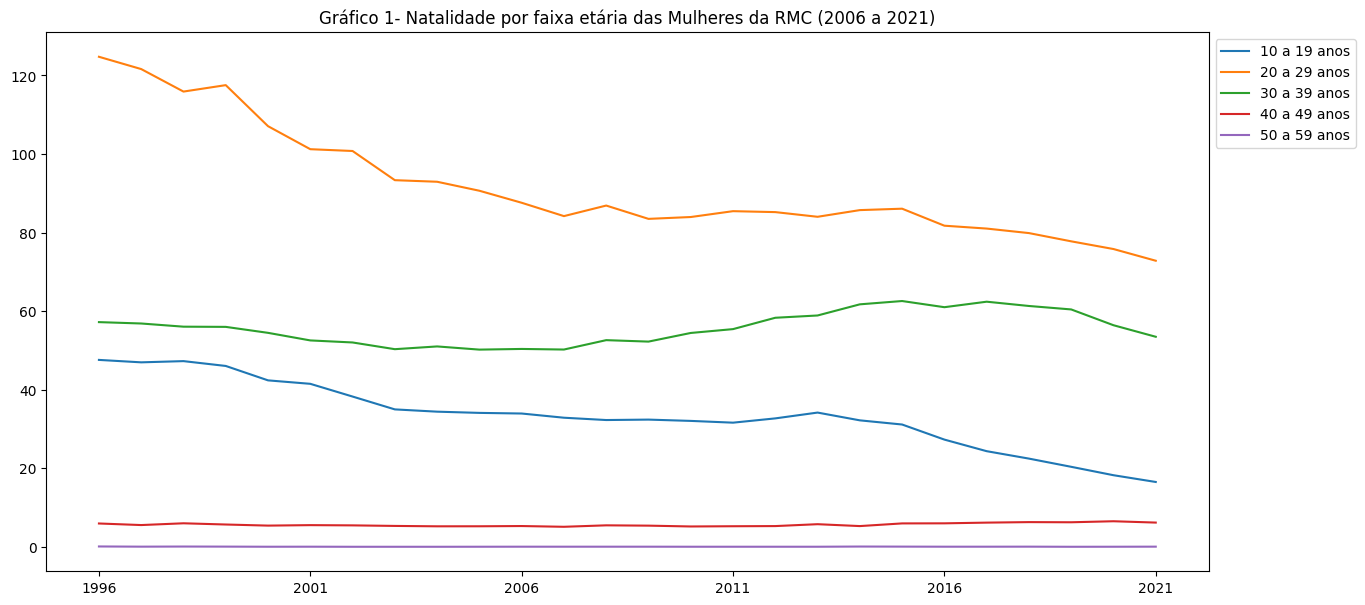

In [9]:
df_natalidade.transpose().plot(kind='line', figsize=(15,7))
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title('Gráfico 1- Natalidade por faixa etária das Mulheres da RMC (2006 a 2021)')
plt.show()

## Modelagem da Variação Anual dos Dados de natalidade

O modelo exponencial, exposto na fórmula adiante, foi aplicado aos dados. A escolha do modelo exponencial se deu pela sua capacidade de representar dinâmicas que tende à padrões assintóticos, que se adequam bem a padrões de saturação em acréscimos ou decréscimos, o que é especialmente importante no caso de diminuição de taxas de natalidade, para as quais não se pode esperar que que permaneçam em diminuição a nível zero.

$$
natalidade = f(ano) = \text{constante} \cdot e^{\text{coeficiente} \cdot (-ano - 1)}
$$

A curva, com seus parâmetros, constante e coeficiente, foi ajustada aos dados com base no biblioteca SciPy - Scientific Python<a name="cite_ref-1"></a>[<sup>[1]</sup>](#cite_note-1). Essa biblioteca ajusta os parâmetros método de Mínimos Quadrados Não Lineares. Esse é um processo que busca a otimização dos quadrados dos resíduos (quadrado da diferença entre valores preditos pelo modelo e valores reais). Nesse processo é utilizado o método de Levenberg-Marquardt, que é o mais comumente utilizado em procedimentos para os quais não se apresentam restrições aos valores a serem testados iterativamente como parâmetros<a name="cite_ref-2"></a>[<sup>[2]</sup>](#cite_note-2).


<a name="cite_note-1"></a>1. [^](#cite_ref-1) https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

<a name="cite_note-2"></a>2. [^](#cite_ref-2) https://sites.cs.ucsb.edu/~yfwang/courses/cs290i_mvg/pdf/LMA.pdf


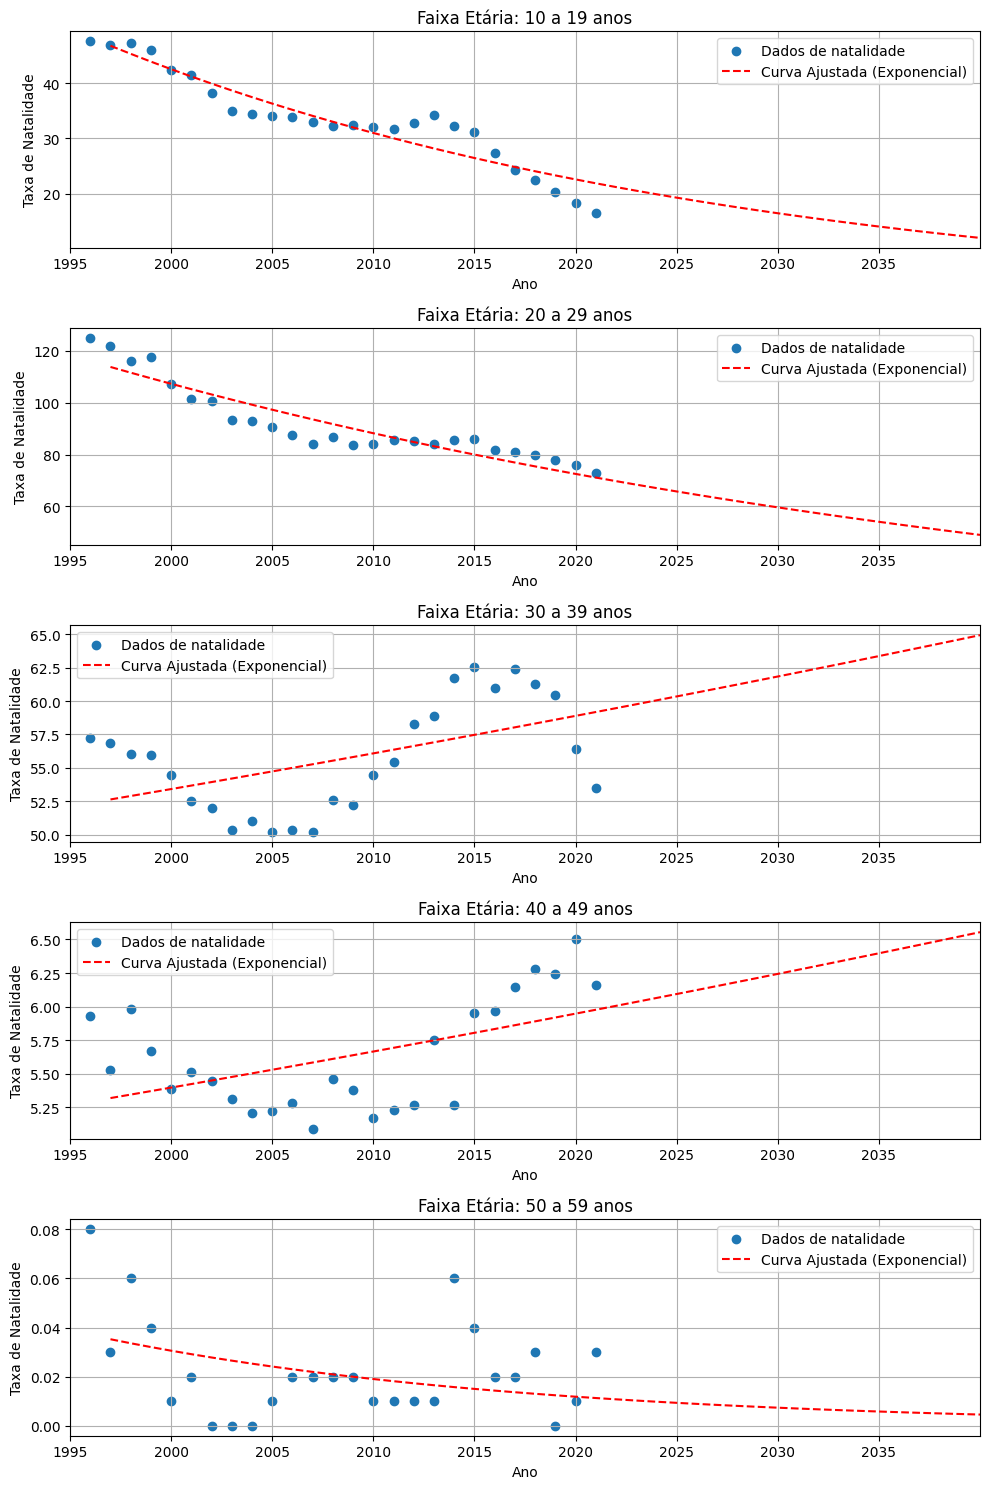

In [10]:
# supressão de mensagens de alerta
np.seterr(over='ignore', invalid='ignore')
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Função para o modelo exponencial decrescente
def modelo_exponencial(x, constante, coeficiente):
    return constante * np.exp(coeficiente * (-x - 1))

# DataFrame de resultados
resultados = pd.DataFrame(columns=['Faixa Etária', 'Constante', 'Coeficiente'])

# Preparação de dados necessários ao lação de iteração
df_natalidade.reset_index(inplace=True)
faixas_etarias = df_natalidade['Faixa Etária'].unique()
num_plots = len(faixas_etarias)
num_colunas = 1
num_linhas = 5

# Criaçao de subplots para cada faixa etária
fig, axs = plt.subplots(num_linhas, num_colunas, figsize=(10, 15))
fig.subplots_adjust(wspace=0.5, hspace=0.5)


# laço de iteração
for i, faixa_etaria in enumerate(faixas_etarias):
    if i >= num_plots:
        break  # Sair se todos os subplots já estiverem preenchidos
    
    # Filtragem do dataFrame para a faixa etária atual
    df_filtro = df_natalidade[df_natalidade['Faixa Etária'] == faixa_etaria]
    
    # Atribuição de dados de anos e natalidade a sua variáveis para o modelo
    anos = np.array(df_filtro.columns[1:], dtype=int) - 1996
    dados_natalidade = df_filtro.iloc[0, 1:].values.astype(float)
    
    # Ajuste do modelo exponencial aos dados
    try:
        params, _ = curve_fit(modelo_exponencial, anos, dados_natalidade, maxfev=10000)
        constante, coeficiente = params
    except RuntimeError:
        constante, coeficiente = np.nan, np.nan
    
    # Criação de um DataFrame temporário com os resultados atuais
    df_temp = pd.DataFrame({'Faixa Etária': [faixa_etaria],
                            'Constante': [constante], 'Coeficiente': [coeficiente]})
    
    # Concatenação do DataFrame temporário ao DataFrame de resultados
    resultados = pd.concat([resultados, df_temp], ignore_index=True)

    # Calculo das previsões do modelo para os anos sob análise, inclusive os futuros, para projeção
    anos_incluso_futuros = np.arange(1, 45)
    previsao = modelo_exponencial(anos_incluso_futuros, constante, coeficiente)
    
    # Plotagem os dados originais e a curva ajustada
    axs[i].scatter(anos + 1996, dados_natalidade, label='Dados de natalidade', marker='o')
    axs[i].plot(anos_incluso_futuros + 1996, previsao, label='Curva Ajustada (Exponencial)', linestyle='--', color='red')
    axs[i].set_xlabel('Ano')
    axs[i].set_ylabel('Taxa de Natalidade')
    axs[i].set_title(f'Faixa Etária: {faixa_etaria}')
    axs[i].legend()
    axs[i].grid(True)
    axs[i].set_xlim(1995, 2040)  # Definir limite do eixo x de 1996 a 2040
    axs[i].set_xticks(np.arange(1995, 2040, 5))  # Definir marcações no eixo x a cada 5 anos



# Exibir os subplots
plt.tight_layout()
plt.show()

In [11]:
new_columns = [*resultados.columns.tolist()]
new_columns.extend(range(2022, 2043))
resultados = resultados.reindex(columns=new_columns, fill_value=0)

for year in resultados.columns[3:].astype(int):
    resultados.loc[:,year] = year-1996

resultados = pd.concat(
    objs=[
        resultados.iloc[:,:3]
        , modelo_exponencial(resultados.iloc[:, 3:], resultados.Constante.values.reshape((5,1)), resultados.Coeficiente.values.reshape((5,1)))
        ]
    , axis=1
    
)

resultados.to_csv(path_or_buf='./source/tab/results/natalidade_projetada_rmc_2022_2042.csv', sep=';', decimal=',', encoding='utf-16')

resultados


,Faixa Etária,Constante,Coeficiente,2022,2023,2024,2025,2026,2027,2028,...,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042
0,10 a 19 anos,49.805478,0.031688,21.169271,20.508978,19.869279,19.249534,18.649119,18.067432,17.503888,...,14.939121,14.473153,14.021719,13.584366,13.160654,12.750158,12.352466,11.967179,11.593909,11.232282
1,20 a 29 anos,118.213251,0.019536,69.756997,68.407449,67.084009,65.786173,64.513446,63.265341,62.041383,...,56.267750,55.179170,54.111650,53.064783,52.038169,51.031417,50.044141,49.075966,48.126521,47.195445
2,30 a 39 anos,52.118332,-0.004885,59.466876,59.758099,60.050749,60.344832,60.640355,60.937325,61.235749,...,62.749938,63.057239,63.366045,63.676364,63.988202,64.301568,64.616468,64.932910,65.250902,65.570451
3,40 a 49 anos,5.268073,-0.004855,6.005979,6.035210,6.064584,6.094100,6.123760,6.153565,6.183514,...,6.335463,6.366298,6.397283,6.428418,6.459706,6.491145,6.522738,6.554484,6.586385,6.618441
4,50 a 59 anos,0.038731,0.047289,0.010803,0.010304,0.009828,0.009374,0.008941,0.008528,0.008134,...,0.006422,0.006125,0.005842,0.005572,0.005315,0.005069,0.004835,0.004612,0.004399,0.004196
